# Install necessary packages

In [40]:
# %pip install flopy geopandas rasterio

# Imports

In [41]:
import flopy
import flopy.utils.binaryfile as bf
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio
import matplotlib.patches as mpatches


# GIS helper functions

In [42]:
def import_raster( file_name ):
  """ Function to import GIS raster files (e.g. GeoTiff files)

  Arguments:
  -file_name: String containing the filename of the file to be opened.
  -return: The function returns two variables. The first is a NumPy array
   containing the image. The second return variable contains the file metadata.
  """

  raster_file = rasterio.open( file_name )
  array = raster_file.read()
  meta = raster_file.meta
  return array, meta



# Helper function to plot georeferenced rasters:
def plot_geo_raster( raster, raster_metadata, title="", colorbar_label="", colorbar_shrink=1 ):
  """ Function to plot georeferenced raster files.

  Arguments:
  - raster: NumPy Array containing the image.
  - raster_metadata: Variable containing the image metadata.
  - title: Figure title (optional)
  - colorbar_label: Label for colorbar (optional)
  - colorbar_shrink: optional argument in case the colorbar is too big. Default = 1

  The function can be used to display images read in by the import_raster function, for example:
  raster, raster_metadata = import_raster( file_name )
  im = plot_geo_raster( raster, raster_metadata, title = "GeoTiff image")

  - return: an AxesImage object
  """

  transform =  raster_metadata.get('transform')
  raster_width_m = raster_metadata.get( 'width' )*transform.a
  raster_height_m = raster_metadata.get( 'height' )*transform.e
  raster_extent = [ transform.xoff, transform.xoff + raster_width_m, transform.yoff + raster_height_m, transform.yoff ]

  if len( raster.shape ) == 3:
    im = plt.imshow( raster[0,:,:], origin='upper', extent=raster_extent)
  if len( raster.shape ) == 2:
    im = plt.imshow( raster, origin='upper', extent=raster_extent)
  if len( raster.shape ) < 2 or len( raster.shape ) > 3 :
    raise Exception('This function requires a 2d array, or a 3d array of height 1')

  plt.title( title )
  # If a colorbar label has been provided, plot a colorbar:
  if len( colorbar_label ) >0 :
    plt.colorbar(im, label=colorbar_label, shrink=colorbar_shrink)
  return im
  return im



def plot_streamlines( model, qx, qy, density ):
  """ Function to plot streamlines for FloPy models. The function is included here as recent changes to
  FloPy result in model.modelgrid.ycellcenters having the wrong order for the MatPlotLib streamplot function.

  Arguments:
  - model: Flopy model, usually called mf
  - qx: Flux in x direction
  - qy: Flux in y-direction
  - density: Density of streamlines. Default 1.0. Higher values give more detailed streamline maps
  but take longer to calculate. Lower values give less detailed streamline maps.
  - return: StreamplotSet object with the streamlines and arrows.
  """

  xcentres = model.modelgrid.xcellcenters
  ycentres = model.modelgrid.ycellcenters
  streamlines = plt.streamplot( np.flipud( xcentres), np.flipud( ycentres), np.flipud( qx ), np.flipud( qy),  density=density )
  return streamlines


# Helper function to plot labels for point data
def plot_labels( points_shapefile, color, label_field="Name"):
  """ Add text labels next to points in a plot

  Arguments:
  - x_coords: x coordinates of points, as NumPy array
  - y_coords: y coordinates of points, as NumPy array
  - labels: labels to be added to the plot, as list of strings
  - color: color of label
  - return: An annotation object
  """
  x_coords = points_shapefile.geometry.x
  y_coords = points_shapefile.geometry.y

  index = [point.lower()  for point in points_shapefile.columns.values].index( label_field.lower() )
  labels = points_shapefile.iloc[:, index]

  for x, y, label in zip( x_coords, y_coords, labels ):
    plt.text( x+200, y, label, color=color)


# Helper function to calculate the cells in which point data (wells) are located.
def coordinates2indices( x, y, raster, raster_metadata ):
  """ Calculates the row and column indices for a set of coordinates and a georeferenced raster.
  This can be used for example to find the row and column inside which a well is
  located, from the well coordinates.

  Arguments:
  - x: x coordinates of points, as 1D NumPy array
  - y: y coordinates of points, as 1D NumPy array
  - raster: Georeferenced raster image as 2D NumPy array
  - raster_metadata: metadata object for the raster.
  - return: Two variables, the first one the columns, the second one the rows.
  """

  transform =  raster_metadata.get('transform')
  raster_width_m = raster_metadata.get( 'width' )*transform.a
  raster_height_m = raster_metadata.get( 'height' )*transform.e

  x = np.array( x )
  y = np.array( y )
  cols = np.trunc( (x - transform.xoff) / transform.a )
  rows = np.trunc( (y - transform.yoff) / transform.e )

  return cols.astype(int), rows.astype(int)


# Helper function to update shapefile dataframe with model rows and cols:
def add_rows_and_cols_to_shapefile( points_shapefile, basin, basin_metadata ):
  """ This function takes a GeoPandas dataframe, created by reading in a shapefile, and
  a georeferenced raster image. It then calculates the image row and column, in which
  each point inside the dataframe is located and adds it to the dataframe.

  Arguments:
  - points_shapefile: The Geopandas dataframe with the points as x and y attributes.
  - basin: Georeferenced raster images stored as a NumPy image.
  - basin_metadata: Metadata object containing the georeferencing of the raster.
  - return: The function returns the GeoPandas dataFrame, to which the fields model_rows
  and model_cols have been added, containing the rows and columns in which the points
  are located.
  """

  cols, rows = coordinates2indices( points_shapefile.geometry.x, points_shapefile.geometry.y, basin, basin_metadata )

  # Add the row and column data to the GeoPandas Dataframe:
  points_shapefile['model_rows'] = rows
  points_shapefile['model_cols'] = cols

  return points_shapefile


def add_rivers_from_grid( rivbound, rivergrid, dem, stage_relative_to_dem, bottom_relative_to_dem ):
  """ Add river cells to a MODFLOW river package boundary list based on the rivergrid array.

  Arguments:
  - rivbound: list of lists with [lay, row, col, stage, cond, rbot] as required for FloPy mfriv
  stress period dictionary. As this function is created to create this data structure, the
  first time the function is called, this will likely be an empty list []
  - rivergrid: A 2D boolean numpy array where True values represent river cells.
  - dem: A georeferenced numpy array representing the digital elevation model of the grid.
  - stage_relative_to_dem: The stage (water level) of the river relative to the elevation of the dem at the same cell.
  This will usually be a negative number, e.g. -1, for a river stage 1m below the elevation of the terrain.
  - bottom_relative_to_dem: The elevation of the bottom of the river channel relative to the elevation of
  the dem at the same cell. This will usually be a negative number e.g. -4.
  - return: rivbound a list of lists, that can be used in the stress period dictionary required for FloPy mfriv.
  """
  rowids = np.where( rivergrid)[1]
  colids = np.where( rivergrid)[2]

  # Zip allows us to loop through two variables together at the same time. So in the first iteration we will have acces to row[0] and col[0], in the next iteration we will have row[1] and col[1], etc.
  for row, col in zip(rowids, colids):
    stage = dem[0, row, col] + stage_relative_to_dem
    rbot  = dem[0, row, col] + bottom_relative_to_dem
    rivbound.append([0, row , col , stage , cond, rbot])
  return rivbound

# Import Raster GIS Data

In [43]:
# Load in Raster files:

# Basin Boundary:
raster_name = 'GIS/basin_boundary_100m_grid_OSGB36.tif'
basin, basin_metadata = import_raster(  raster_name )
basin_inside = 1
basin_outside = 0

# Conductivity areas
raster_name = 'GIS/conductivity_areas_100m_OSGB36.tif'
K_areas, K_areas_metadata = import_raster(  raster_name )
K_areas[ basin==basin_outside ] =0

# Recharge areas
raster_name = 'GIS/recharge_areas_100m_OSGB36.tif'
recharge_areas, recharge_areas_metadata = import_raster(  raster_name )
recharge_areas[ basin==basin_outside] =0

# Rivers
raster_name = 'GIS/rivers_100m_OSGB36.tif'
rivers, rivers_metadata = import_raster(  raster_name )
# remove any river cells outside the basin area:
rivers[ basin==basin_outside] =0

# Digital Elevation Model (DEM)
raster_name = 'GIS/dem_100m_OSGB36.tif'
dem, dem_metadata = import_raster(  raster_name )

# Landfill location
landfill_filename = 'GIS/Landfill_100m_osgb36.tif'
landfill, landfill_metadata = import_raster(  landfill_filename )


In [44]:
plot_figures_preprocessing = False

if plot_figures_preprocessing :
  plt.figure(figsize=(20,30))

  plt.subplot(3,2,1)
  plot_geo_raster(raster=basin, raster_metadata=basin_metadata, title='Basin Boundary')

  plt.subplot(3,2,2)
  plot_geo_raster(raster=K_areas, raster_metadata=K_areas_metadata, title='Hydraulic conductivity areas', colorbar_label='Index value')

  plt.subplot(3,2,3)
  plot_geo_raster(raster=recharge_areas, raster_metadata=recharge_areas_metadata, title='Recharge Areas', colorbar_label = 'Index Value' )

  plt.subplot(3,2,4)
  plot_geo_raster(raster=rivers, raster_metadata=rivers_metadata, title='Rivers', colorbar_label='Index Value')

  plt.subplot(3,2,5)
  plot_geo_raster(raster=dem, raster_metadata=dem_metadata, title='Digital elevation model (sinks removed)', colorbar_label='Surface Elevation (m)')


# Import Vector GIS Data

In [45]:
# Import vector data

# Load in shapefiles for well locations. This creates a GeoPandas data frame with the data from the shapefile.
# Observation wells

observation_wells_shapefile = 'GIS/vector_data/wells_observation_OSGB36.shp'

observation_wells_sf = gpd.read_file( observation_wells_shapefile )
observation_wells_sf = add_rows_and_cols_to_shapefile( observation_wells_sf, basin, basin_metadata )

# Abstraction wells
pumping_wells_shapefile = 'GIS/vector_data/wells_pumping_OSGB36.shp'
pumping_wells_sf = gpd.read_file( pumping_wells_shapefile )
pumping_wells_sf = add_rows_and_cols_to_shapefile( pumping_wells_sf, basin, basin_metadata )

# Load in rivers
rivers_shapefile = 'GIS/vector_data/Rivers.shp'
rivers_sf = gpd.read_file( rivers_shapefile )

# Load in hospital well shapefile
hospital_shapefile = 'GIS/Hospital_osgb36.shp'
hospital_sf = gpd.read_file( hospital_shapefile )
hospital_sf  = add_rows_and_cols_to_shapefile( hospital_sf, basin, basin_metadata )

landfill_shapefile = 'GIS/Landfill_osgb36.shp'
landfill_sf = gpd.read_file( landfill_shapefile )


In [46]:
# Make a figure of the well locations. Use the DEM as a basemap.
if plot_figures_preprocessing :
  fig = plt.figure( figsize=(15,15) )
  ax = plt.subplot(1,1,1)
  plot_geo_raster(dem ,dem_metadata )

  observation_wells_sf.plot(color='white', ax=ax)
  plot_labels( observation_wells_sf, color="white")

  pumping_wells_sf.plot(color='yellow', ax=ax)
  plot_labels( pumping_wells_sf, color="yellow")

  rivers_sf.plot(color='lightskyblue', ax=ax)


# Create the model:

In [47]:
modelname = 'Dumfries'
# Create the model as an object. Tell FloPy we want to use MODFLOW 2005:
mf = flopy.modflow.Modflow(modelname, exe_name='mf2005')

# Define the model grid geometry:

In [48]:
#Spatial discretization:
raster_shape = K_areas.shape

nrow = raster_shape[1]   # number of cells in y-direction
ncol = raster_shape[2]   # number of cells in x-direction

delr = 100  # cell size in x-direction, values as used in GIS
delc = 100  # cell size in y-direction

Lx = ncol*delc
Ly = nrow*delr

nlay = 11    # number of layers

# Use DEM to guide model top and layer geometries
ztop = dem[0,:,:]                 # model top elevation
superficial_deposits = ztop - 20  # 20m thickness of superficial deposits
#bedrock_aquifer = ztop - 220      # 200m thickness of bedrock aquifer

botm = np.zeros( [nlay, nrow, ncol] )
botm[0,:,:] = superficial_deposits
for i in range(1,nlay):
  botm[i,:,:] = ztop -20 - 20*i


# Define Stress periods

In [49]:
# Set number of stress periods:
nper = 1
# Set length of each stress period:
perlen = [1]
# Number of time steps in each stress period:
nstp = [1]
# Are stress periods steady-state (True) or transient (False):
steady = [True]

# Create the discretization object:
dis = flopy.modflow.ModflowDis(mf, nlay, nrow, ncol, delr=delr, delc=delc, top=ztop, botm=botm, nper=nper, perlen=perlen, nstp=nstp, steady=steady)

# Model georeferencing

In [50]:
# Determine the georeferencing parameters from the MetaData:
transform = basin_metadata.get('transform')
xul = transform.c
yul = transform.f
crs_epsg = basin_metadata.get('crs').to_epsg()

# Set the model georeferencing. This does not affect the model results in any way, but ties the grid to the correct location.
mf.modelgrid.set_coord_info(xoff=xul, yoff=yul-nrow*delc, angrot=0,epsg=crs_epsg)


c:\Users\yisih\miniforge3\Lib\site-packages\flopy\utils\crs.py:121: PendingDeprecationWarning: the epsg argument will be deprecated and will be removed in version 3.6. Use crs instead.
  warnings.warn(


# Boundary conditions

In [51]:
# Define boundary conditions:
# This is done with a matrix, the same dimensions as the modelling grid. The value of each element
# in this matrix tells MODFLOW how to treat the cell in the model. Where:
# - IBOUND > 0  This cell is active in the model, it's value is determined by the model.
# - IBOUND < 0  This cell has a constant head, it is a constant head boundary condition
# - IBOUND = 0  This cell is inactive, so it acts as a no-flow boundary.

active_cell = 1
inactive_cell = 0

# Create a NumPy matrix, the size of our grid. Fill it with ones, use in32 as the datatype
ibound = np.ones((nlay, nrow, ncol)) * inactive_cell

#Make only the cells inside the basin boundary active
ibound[:, basin[0,:,:] == basin_inside ] = active_cell

# Visualize the results
if plot_figures_preprocessing:
  plt.figure(figsize=(30,5))
  plt.subplot(1,nlay,1)
  im = plt.imshow( ibound[0,:,:])
  plt.title('Top layer')

  for i in range(1, nlay):
    plt.subplot(1,nlay,i+1)
    plt.imshow( ibound[i,:,:])
    plt.title('Bedrock layer: ' +str(i))

  legend_patches = [ mpatches.Patch(color=im.cmap(im.norm(0)), label='inactive cells'), mpatches.Patch(color=im.cmap(im.norm(1)), label='active cells') ]
  plt.legend(handles=legend_patches, loc=2,  borderaxespad=0. , bbox_to_anchor=(1.05, 1) )


# Add rivers

In [52]:
#Calculate parameters for the river package (RIV) and set up rivers using the rivers grid

# Nith and Lochar
riverbed_thickness = 1  #m
riverbed_K = 1e-1       #m/day,
# Calculate riverbed  conductance:
A = 100 * 50    # in a typical grid cell the river will be 100m long, but not necessarily
                # 100m wide, here we pick a width of 50m as an appropriate value.

cond = riverbed_K*A/riverbed_thickness

nith_stage_relative_to_dem =  -1     # Head in the river is 1m below than surface elevation
nith_rbot_relative_to_dem  =  -4    # Elevation of river bottom

lochar_stage_relative_to_dem =  -1     # Head in the river is 0.7m higher than surface elevation
lochar_rbot_relative_to_dem  =  -4    # Elevation of river bottom

# Create a river stress period dictionary:
rivbound = []

rivbound = add_rivers_from_grid( rivbound, rivers == 1, dem, nith_stage_relative_to_dem, nith_rbot_relative_to_dem)
rivbound = add_rivers_from_grid( rivbound, rivers == 2, dem, lochar_stage_relative_to_dem, lochar_rbot_relative_to_dem)

# Create dictionary for each time step
river_stress_period_data = { 0: rivbound}

# Add river package to model:
riv = flopy.modflow.ModflowRiv(mf, stress_period_data=river_stress_period_data  )


# Add a well

In [53]:
# Well layer location
well_layer = 1

# Create a data structure for all the wells:
wellbound = []

# Simultaneously loop through all the well rows, well columns and well fluxes:
for well_row, well_col, well_flux in zip( pumping_wells_sf.model_rows, pumping_wells_sf.model_cols,  pumping_wells_sf.pump_rate  ) :
  wellbound.append( [well_layer, well_row, well_col, float(well_flux) * -1000]) # flux is multiplied by -1000, as the values in the shape file are in megalitres/day
                                                                                # here we need to  convert these to m3/day. The values in the shapefile are positive
                                                                                # so we need to make the number negative, so MODFLOW treats them as abstraction wells,
                                                                                # rather then injection wells.

# Add the hospital well to our boundary conditions:
hospital_row = hospital_sf.iloc[0].model_rows
hospital_col = hospital_sf.iloc[0].model_cols
hospital_flux =  - 1200 * 350 *1.1 *1e-3 # m3/day   (1200l per bed * 350 beds * +10% * litres to m3)
wellbound.append( [well_layer, hospital_row, hospital_col, hospital_flux])


# Create well stress period dictionary:
well_stress_period_data = { 0: wellbound }

# Add wells to MODFLOW:
wel = flopy.modflow.ModflowWel(mf, stress_period_data=well_stress_period_data)


# Add recharge

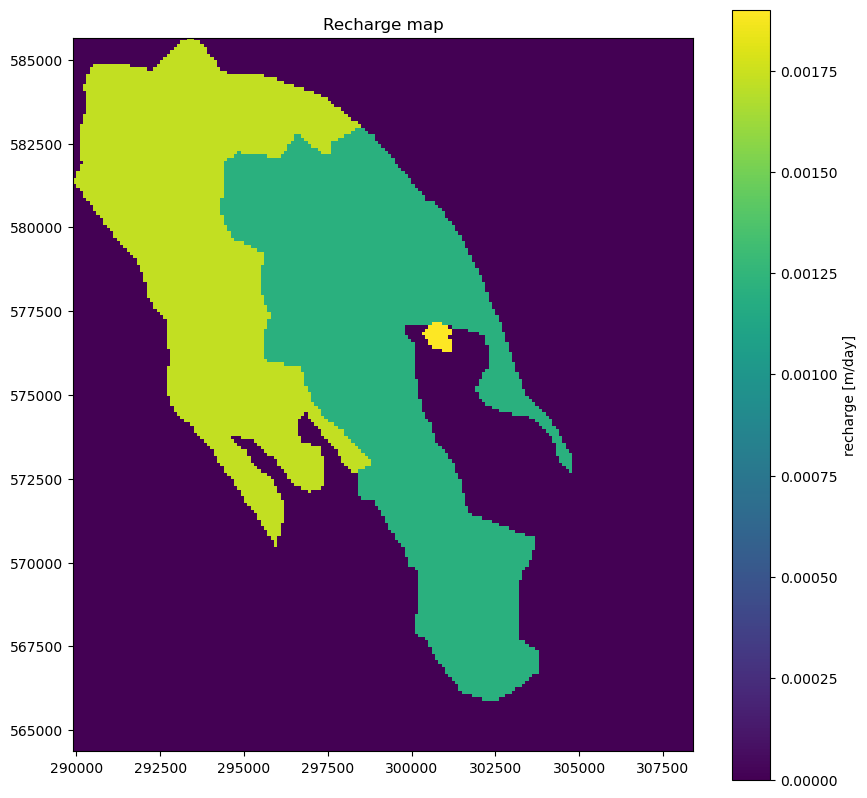

In [54]:
# Add recharge to model:

# Enter recharge values from table. Convert to m/day.
r1 = 0 # m/day
r2 = 1.4e-8 *3600*24 # m/s to m/day
r3 = 2.0e-8 *3600*24 # m/s to m/day

# Assign table values to areas:
rechargemap = np.zeros( [nrow, ncol])
rechargemap[ recharge_areas[0,:,:] == 1 ] = r1
rechargemap[ recharge_areas[0,:,:] == 2 ] = r2
rechargemap[ recharge_areas[0,:,:] == 3 ] = r3

# Adjust recharge map to incorporate the landfill:
landfill_recharge = 2.2e-8 # m/s
landfill_recharge = landfill_recharge * 60*60*24 # m/day

rechargemap[ landfill[0,:,:] == 1 ] = landfill_recharge


# Assign to model
rch = flopy.modflow.ModflowRch(mf, rech=rechargemap)

# Plot a figure
plt.figure( figsize=(10,10))
im = plot_geo_raster( raster=rechargemap, raster_metadata=recharge_areas_metadata, title='Recharge map', colorbar_label='recharge [m/day]')


# Hydraulic head at start of model:

In [55]:
# Set the initial hydraulic heads in the model. This is done by setting values in a matrix the same
# size as the model grid. Heads are set regardless of the boundary condition status of the cell.
# Heads assigned to constant head boundary condition cells (IBOUND < 0) will become the head value
# used for the boundary condition.


strt = np.zeros( (nlay, nrow, ncol) )



# With IBOUND and STRT assigned, we have all the parameters we need for the Basic (BAS) package:
bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)

# Hydraulic conductivity:


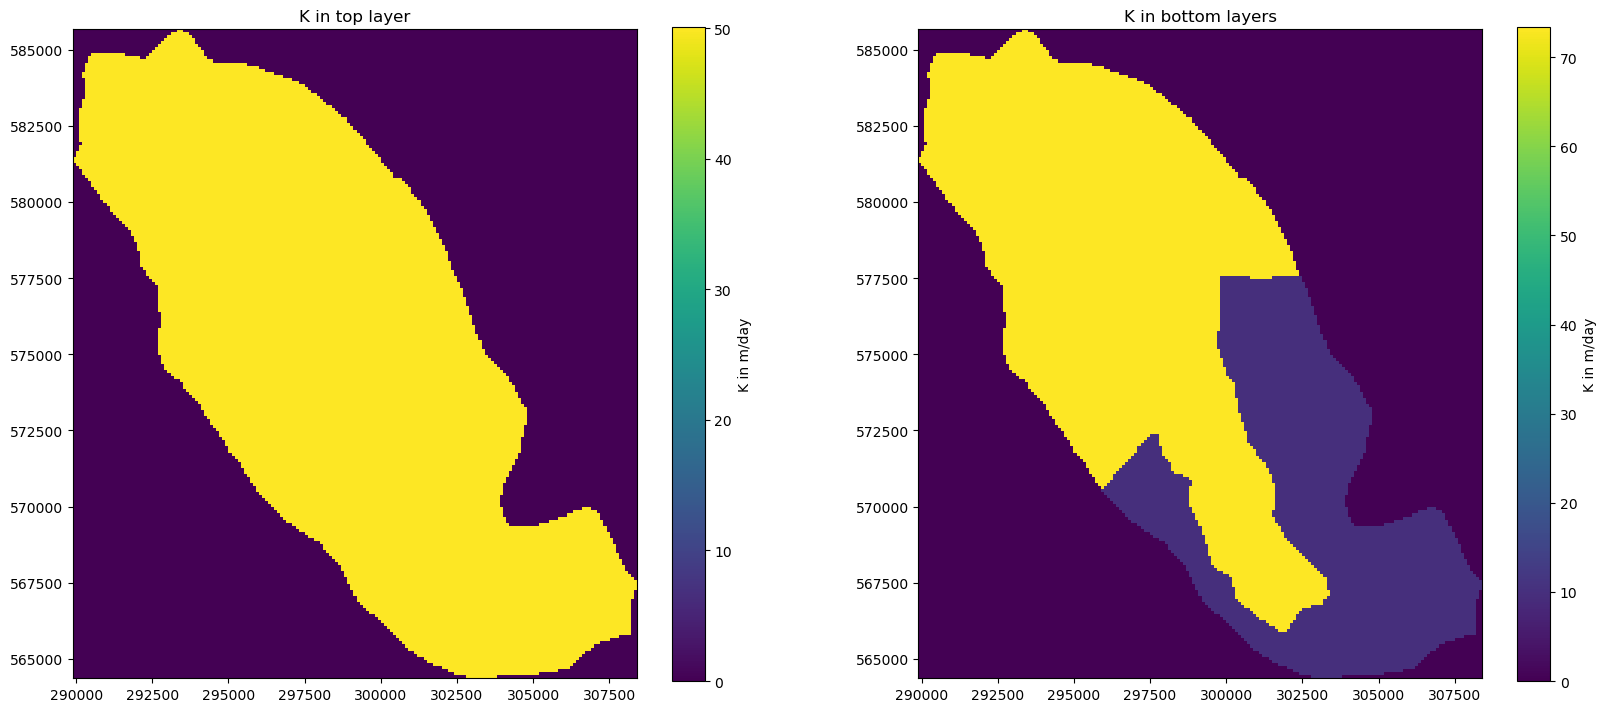

In [56]:
# Create a matrix with the hydraulic conductivity (K) value for every cell in the model.
# Here I am assuming an isotropic hydraulic conductivity (so the same in all directions).

# Create conductivity matrix
K = np.zeros((nlay, nrow, ncol))

# Hydraulic conductivity values:

K_multiplier = 50

Ksup = 5.8e-4 * 60*60*24 #m/day  Superficial deposits
K1   = 1.7e-5 * 60*60*24  *K_multiplier #m/day   K Area 1
K2   = 1.7e-5 * 60*60*24   *K_multiplier#m/day   K Area 2
K3   = 1.7e-5 * 60*60*24   *K_multiplier#m/day
K4   = 1.7e-5 * 60*60*24   *K_multiplier#m/day
K5   = 1.7e-5 * 60*60*24  *K_multiplier #m/day
K6   = 2.3e-6 * 60*60*24   *K_multiplier#m/day

# Create hk matrix
hk = np.zeros( [nlay, nrow, ncol])

# In top layer assign superficial K everywhere:
hk[ 0, basin[0,:,:] == basin_inside ] = Ksup

# Assign table values to areas in lower layer:
hk[ 1:, K_areas[0,:,:] == 1 ] = K1
hk[ 1:, K_areas[0,:,:] == 2 ] = K2
hk[ 1:, K_areas[0,:,:] == 3 ] = K3
hk[ 1:, K_areas[0,:,:] == 4 ] = K4
hk[ 1:, K_areas[0,:,:] == 5 ] = K5
hk[ 1:, K_areas[0,:,:] == 6 ] = K6

# For transient model we need values for specific yield:
sy = 0.2
# And we need specific storage:
ss = 1.0e-4

# Add LPF package to the MODFLOW model
lpf = flopy.modflow.ModflowLpf(mf, hk=hk, layvka = 1, vka=1.0, ss=ss, sy=sy, ipakcb=53)

# Plot everything in a figure:
plt.figure( figsize=(20,10))
plt.subplot(1,2,1)
plot_geo_raster( raster=hk[0,:,:], raster_metadata=K_areas_metadata, title='K in top layer', colorbar_label = 'K in m/day', colorbar_shrink = 0.85 )
plt.subplot(1,2,2)
plot_geo_raster ( raster=hk[-1,:,:], raster_metadata=K_areas_metadata, title='K in bottom layers', colorbar_label = 'K in m/day', colorbar_shrink = 0.85 )


# Set output file options:

In [57]:
# In MODFLOW you can specify what model data you want to write to the output file. You need to specify
# this for every stress period and time step.

# Create empty dictionary:
stress_period_data = {}

# Two for loops to loop through stress periods, and for each stress perido loop through the time steps:
for kper in range(nper):
    for kstp in range(nstp[kper]):
        stress_period_data[(kper, kstp)] = ["save head", "save drawdown", "save budget", "print head", "print budget" ]

# Add OC package to the MODFLOW model
oc = flopy.modflow.ModflowOc( mf, stress_period_data=stress_period_data, compact=True )


# Add a solver:

In [58]:
# Add PCG package to the MODFLOW model
pcg = flopy.modflow.ModflowPcg(mf, mxiter=100, iter1=60)

#Link to MT3DMS

In [59]:
# Here we add the LMT6 (MT3DMS Link-package). This allows MT3DMS to use data from the MODFLOW simulation:
lmt = flopy.modflow.ModflowLmt(mf)


# Visualize grid and boundary conditions:

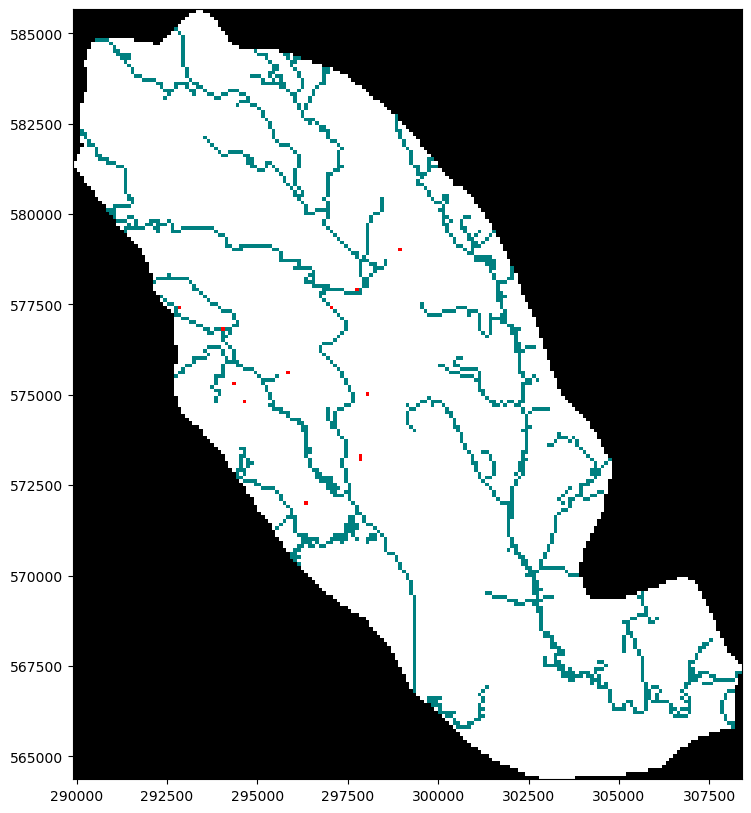

In [60]:
# Plot the top layer

fig = plt.figure(figsize=(15, 10))
mapview = flopy.plot.PlotMapView(model=mf)
mapview.plot_ibound()
mapview.plot_bc("RIV")
mapview.plot_bc("WEL", plotAll=True)


# Run the model:

In [61]:
# Write the MODFLOW model input files
mf.write_input()

# Run the model
mf.run_model()



FloPy is using the following executable to run the model: mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: Dumfries.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2025/03/17  0:37:41

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2025/03/17  0:37:49
 Elapsed run time:  8.107 Seconds

  Normal termination of simulation


(True, [])

# Load in results

In [62]:
# Load in heads:
hds = bf.HeadFile(modelname + '.hds')
# Load in the cell budget file, this contains the flow in and out of each cell:
cbb = bf.CellBudgetFile(modelname + '.cbc')
times = hds.get_times()


# Check mass balance

In [63]:
# Load the budget data
mf_list = flopy.utils.MfListBudget(modelname+ ".list")
# Get data for first time step of the first stress period (kstkper=0), our model has only one stress period with one time step.
budget = mf_list.get_data(kstpkper=(0,0))

# Print the budget data to the screen
for i in range(budget.size):
  print( str( budget['name'][i] ) + " = " + str( budget['value'][i]) )


b'STORAGE_IN' = 0.0
b'CONSTANT_HEAD_IN' = 0.0
b'WELLS_IN' = 0.0
b'RIVER_LEAKAGE_IN' = 719686.4
b'RECHARGE_IN' = 184947.84
b'TOTAL_IN' = 904634.25
b'STORAGE_OUT' = -0.0
b'CONSTANT_HEAD_OUT' = -0.0
b'WELLS_OUT' = -33362.0
b'RIVER_LEAKAGE_OUT' = -871272.25
b'RECHARGE_OUT' = -0.0
b'TOTAL_OUT' = -904634.25
b'IN-OUT' = 0.0
b'PERCENT_DISCREPANCY' = 0.0
b'tslen' = 1.875


# Visualize top aquifer in first stress period

In [64]:
# Make a figure for the first stress period, top aquifer

# Get the first time step, this is the end result of the first stress period,
# which consists of a single steady state time step:
time_to_plot = times[0]

# Get the data for the selected time step and work with that:
head = hds.get_data(totim=time_to_plot)

head[head == -999.99] = np.nan
# Flow Right face, is the flow through the right face of each cell, so the left to right flux.
qx = cbb.get_data(text='FLOW RIGHT FACE', totim=time_to_plot)[0]
# Flow Front face, is the flow through the right front of each cell, soin our map view it's north-south flow.
qy = cbb.get_data(text='FLOW FRONT FACE', totim=time_to_plot)[0]
# Flow Lower face, is the flow through the bottom of each cell, so it is up-down flow
qz = cbb.get_data(text='FLOW LOWER FACE', totim=time_to_plot)[0]



In [65]:
def plot_rivers_and_wells():
  rivers_sf.plot(color='lightskyblue', ax=ax)
  plt.plot( pumping_wells_sf.geometry.x, pumping_wells_sf.geometry.y, 'b+')
  plt.plot( observation_wells_sf.geometry.x, observation_wells_sf.geometry.y, 'k+')

# Set a flag to determine whether to plot the figures or not
plot_figures_postprocessing = False

if plot_figures_postprocessing:
  # Create a figure with multiple subplots
  plt.figure( figsize=(20,20))

  # Plot hydraulic head in a map view for the top layer
  ax = plt.subplot(2,2,1)
  im = plot_geo_raster( head[0,:,:], basin_metadata)
  plt.title('Hydraulic head top aquifer')
  plt.colorbar( im, label='Hydraulic Head [m]')
  plot_rivers_and_wells()

  # Plot streamlines for the top aquifer and top layer
  ax = plt.subplot(2,2,2)
  plot_streamlines( mf, qx[0,:,:], -qy[0,:,:], 1)
  plt.title('Stream lines top aquifer')
  plot_rivers_and_wells()

  # Plot hydraulic head in a map view for the bottom layer
  ax = plt.subplot(2,2,3)
  im = plot_geo_raster( head[-1,:,:], basin_metadata)
  plt.title('Hydraulic head bottom aquifer')
  plt.colorbar( im, label='Hydraulic Head [m]')
  plot_rivers_and_wells()

  # Plot stream lines in a map view for the bottom aquifer
  ax = plt.subplot(2,2,4)
  plot_streamlines( mf, qx[-1,:,:], -qy[-1,:,:], density=1)
  plt.title('Stream lines bottom aquifer')
  plot_rivers_and_wells()


# Cross section

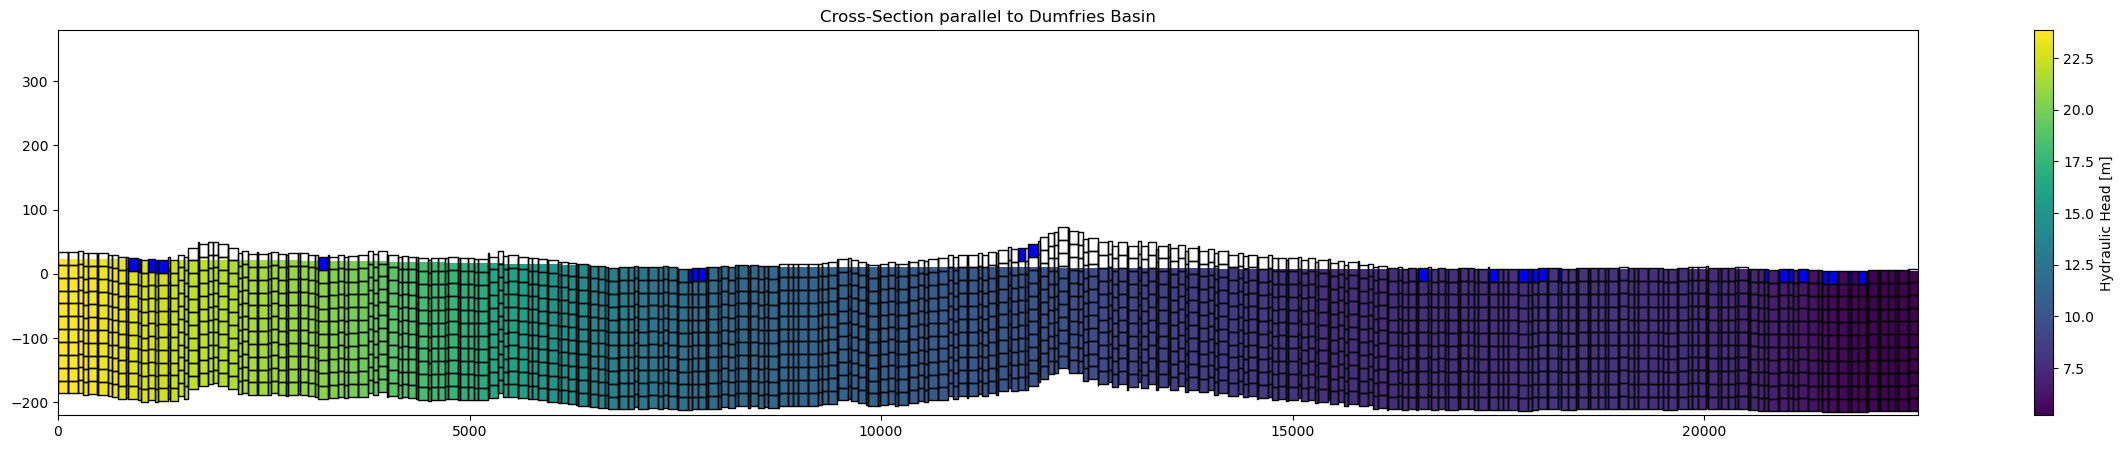

In [66]:
# Figure parallel to basin

fig = plt.figure(figsize=(30, 5))

# Add the cross section, this draws a cross section parallel to the basin
xsect = flopy.plot.PlotCrossSection(model=mf, line={'Line': [[292509, 584389], [305374, 565740]]})

# Plot the head:
headplot = xsect.plot_array(head, head=head)
# Add boundary conditions
xsect.plot_ibound(color_noflow='black', color_ch='red')
# Add rivers:
xsect.plot_bc("RIV", color='blue')
# Add wells:
xsect.plot_bc('WEL', color='pink')
# Draw grid lines:
xsect.plot_grid(color='black')
# Add title:
plt.title('Cross-Section parallel to Dumfries Basin')
# Add title:
fig.colorbar( headplot, label='Hydraulic Head [m]' )


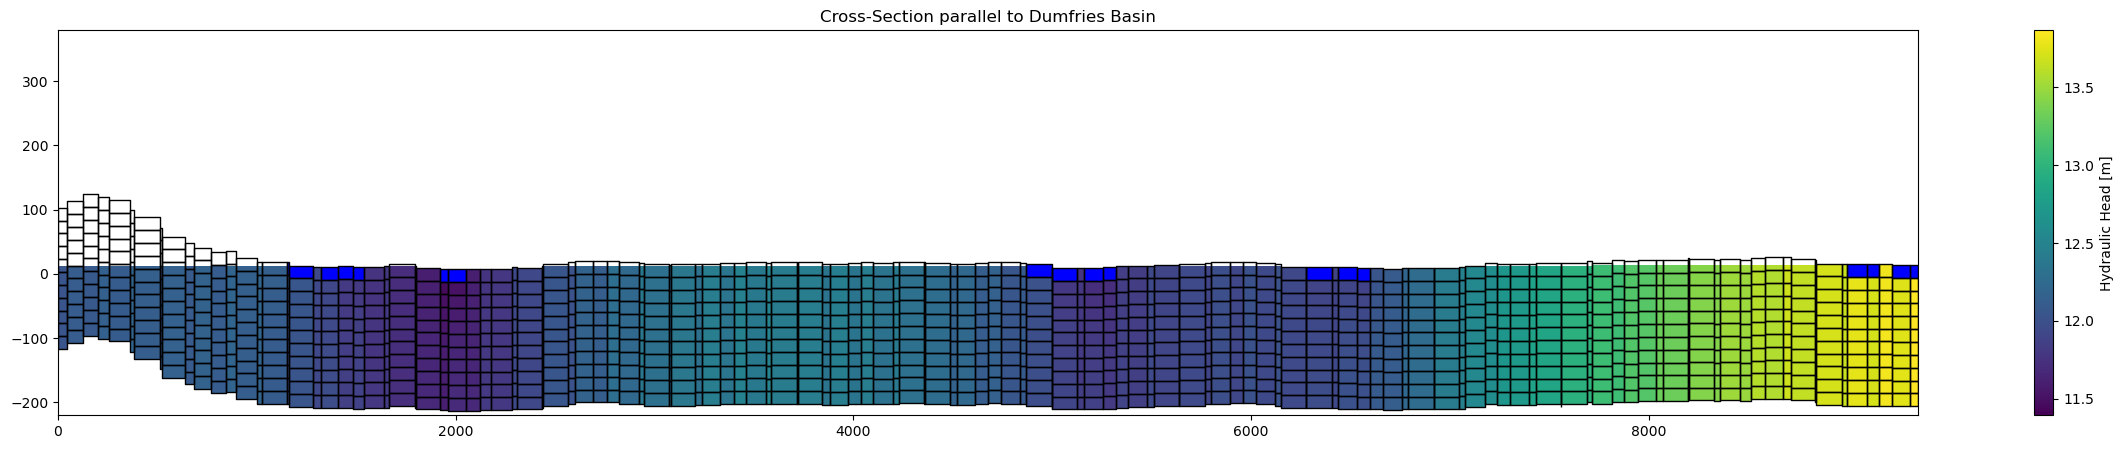

In [67]:
# TODO Figure perpendicular to basin

fig = plt.figure(figsize=(30, 5))

# Add the cross section, this draws a cross section parallel to the basin
xsect = flopy.plot.PlotCrossSection(model=mf, line={'Line': [[292850, 574602], [300265, 580545]]})

# Plot the head:
headplot = xsect.plot_array(head, head=head)
# Add boundary conditions
xsect.plot_ibound(color_noflow='black', color_ch='red')
# Add rivers:
xsect.plot_bc("RIV", color='blue')
# Add wells:
xsect.plot_bc('WEL', color='pink')
# Draw grid lines:
xsect.plot_grid(color='black')
# Add title:
plt.title('Cross-Section parallel to Dumfries Basin')
# Add title:
fig.colorbar( headplot, label='Hydraulic Head [m]' )


#Modelled heads vs observed heads

In [68]:
# Calculate the heads in the wells and the differences with observed heads

# Copy the key data from the shape file to a new GeoPandas DataFrame:
wells_table = observation_wells_sf[[ 'Name', 'Obs_head']].copy()

# Add the modelled heads:
modelled_head_in_wells = head[ well_layer, observation_wells_sf.model_rows,  observation_wells_sf.model_cols ]
wells_table['Modelled_heads'] = modelled_head_in_wells

# Calculate the difference between observed and modelled for each well
observed_heads = wells_table.Obs_head.to_numpy().astype(float)
differences = observed_heads - modelled_head_in_wells
wells_table['Difference'] = differences
# Calculate the sum of squared differences as a summary statistic
sum_of_squared_residuals = np.sum( differences**2)

# Display the data frame and sum of squared differences:
print( wells_table )
print( )
print( 'Sum of Squared Residuals ', sum_of_squared_residuals )


                    Name Obs_head  Modelled_heads  Difference
0         Carnation No 1      7.3       11.700484   -4.400484
1       Dundas Chemicals     14.2       10.869334    3.330666
2            Golf Course      8.2       10.994372   -2.794372
3             Greenmerse      7.9        5.572970    2.327030
4     Holywood Fish Farm        7       14.932282   -7.932282
5        Holywood Pro BH     13.8       17.194824   -3.394824
6             ICI BH 401      8.5       10.752684   -2.252684
7             ICI BH 403     13.3       10.612135    2.687865
8             ICI BH 404      3.3       11.092322   -7.792322
9             ICI BH 501      1.8       11.018376   -9.218376
10           ICI BH No 2     12.8       10.902772    1.897228
11         Kingholm Mill      7.6        8.079820   -0.479820
12     Larchfield Obs BH     12.2        9.953087    2.246913
13     Larchfield Pro BH     12.6        9.903505    2.696495
14        Locharbriggs 1     13.1       13.707328   -0.607328
15      

# Transport post-processing: Particle Tracking

In [69]:
# Set up a ModPath6 model, and specifies the MODFLOW model files to uses as input:
mp = flopy.modpath.Modpath6(modelname=modelname, exe_name='mp6', modflowmodel=mf, dis_file= modelname+'.dis', head_file=modelname+'.hds', budget_file=modelname+'.cbc')

# Porosity has no impact on the steady-state flow solution, but does affect travel times, so we need to include it here.
porosity = 0.2
# Set up basic Modpath parameters:
mpb = flopy.modpath.Modpath6Bas(mp, hdry=mf.lpf.hdry, laytyp=mf.lpf.laytyp, ibound=ibound, prsity=porosity)

# Create the particles, we are adding our particles to the wells, we then backtrack them, so we can see where water entering the well comes from:
sim = mp.create_mpsim(trackdir='forward', simtype='pathline', packages='RCH', start_time=(0, 0, 1))
mp.write_input()

# Run the MODPATH post-processing
mp.run_model(silent=False)


FloPy is using the following executable to run the model: mp6.exe
Processing basic data ...
Checking head file ...
Checking budget file and building index ...
 
Run particle tracking simulation ...
Processing Time Step     1 Period     1.  Time =  1.00000E+00                                                                       
Particle tracking complete. Writing endpoint file ...                                                                               
End of MODPATH simulation. Normal termination.


(True, [])

Text(0.5, 1.0, 'Starting points well particles')

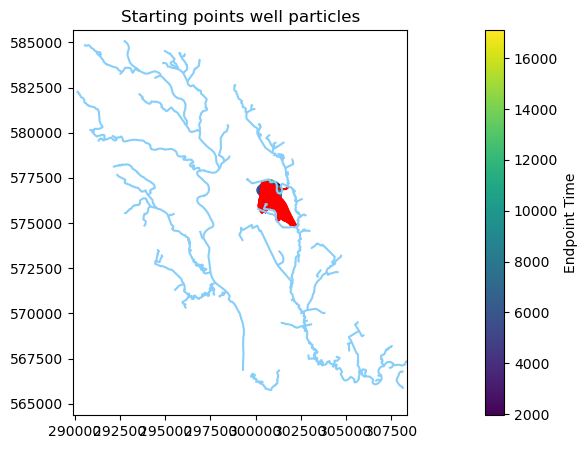

In [70]:
# Load particle simulation endpoints:
epobj = flopy.utils.EndpointFile( modelname+'.mpend' )

# Load pathlines:
pthobj = flopy.utils.PathlineFile(modelname+ '.mppth')

landfill_cell_indices = np.where( landfill == 1)
landfill_cells =[]
for i in range( 0,  len( landfill_cell_indices[0])) :
  landfill_cells.append( (landfill_cell_indices[0][i], landfill_cell_indices[1][i], landfill_cell_indices[2][i] ))

landfill_epd = epobj.get_destination_endpoint_data(dest_cells=landfill_cells, source=True)
# Load pathlines:
landfill_pathlines = pthobj.get_destination_pathline_data(dest_cells=landfill_cells)

# Starting points figure:
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
mapview = flopy.plot.PlotMapView(model=mf, layer=0)
mapview.plot_endpoint(landfill_epd, direction="starting", colorbar=True)
mapview.plot_pathline(landfill_pathlines, layer="all", colors="red");
rivers_sf.plot(color='lightskyblue', ax=ax,)
plt.title('Starting points well particles') # We are tracking them backwards, so the start points become the end points


# Transport Post-processing: MT3DMS

In [71]:
# Set up MT3DMS model:
modelname_mt = modelname + '_mt'
mt = flopy.mt3d.Mt3dms(modelname=modelname_mt, exe_name='mt3dms', modflowmodel=mf)


# MT3DMS Discretization and BCS

In [72]:
icbund = np.zeros( [nlay,nrow, ncol])
icbund[:, basin[0,:,:]==basin_inside] = 1

# Porosity can be set as a single scalar value applying everywhere, or as an (nlay, nrow, ncol) matrix which specifies it for each cell.
# Here we will just use the same value as in MODPATH:
prsity = porosity

# Starting concentration can be set as a single scalar value applying everywhere, or as an (nlay, nrow, ncol) matrix which specifies it for each cell.
starting_concentration = 0

# MT3DMS time steps:
# Stress period length:
year = 365
perlen_mt = [ 1*year, 2*year, 5*year, 10*year, 32*year, 50*year ]
# number of stress period:
nper_mt = len(perlen_mt)
# Number of time steps in stress period:
nstp_mt = np.ones(nper_mt)

# Set up MT3DMS boundary conditions:
btn = flopy.mt3d.Mt3dBtn(mt, icbund=icbund, prsity=prsity, sconc=starting_concentration, perlen=perlen_mt,  nper=nper_mt, nstp=nstp_mt, ttsmult=1.1)


# Advective Transport

In [73]:
# Parameters for advective transport:
mixelm = 0
# MIXELM determines which algorithm to use fo advection:
#  0: standard finite difference, NADVFD can set further options
#  1: forward-tracking method of characteristics (MOC)
#  2: backward-tracking modified method of characteristics (MMOC)
#  3: automatically select HMOC or MOC
# -1: third-order TVD scheme (ULTIMATE).

# Add advective transport to model:
adv = flopy.mt3d.Mt3dAdv(mt, mixelm=mixelm)


# Dispersive Transport:

In [74]:
# Parameters for dispersive transport:
longitudinal_dispersivity = 2.5
transverse_dispersivity = 0.5
trpt = transverse_dispersivity / longitudinal_dispersivity
effective_molecular_diffusion_coeff = 0.05

# Add dispersive transport to model
dsp = flopy.mt3d.Mt3dDsp(mt, al=longitudinal_dispersivity, trpt=trpt, dmcoef=effective_molecular_diffusion_coeff)


# Concentrations

In [75]:
itype = flopy.mt3d.Mt3dSsm.itype_dict()
river_BC_type = itype['RIV']
well_BC_type = itype['WEL']
constant_concentration_BC_type = itype['CC']

bound_mt = []

# Start with the rivers, we'll just use the dictionary from MODFLOW (RIVBOUND)

# concentration of species 1 in river:
rivconc = 0
for riv in rivbound:
  layer = 0
  row = riv[1]
  col = riv[2]
  bound_mt.append( [layer, row, col, rivconc, river_BC_type] )

# Next the wells, we'll just use the dictionary from MODFLOW (WELLBOUND)

# concentration of species 1 in wells:
wellconc = 0
for well in wellbound:
  layer = 1
  row   = well[1]
  col   = well[2]
  bound_mt.append( [layer, row, col, wellconc, well_BC_type] )

# Lastly we want to set the landfill site up as a constant concentration boundary condition. Recharge will
# feed water into the model at this site and this water will get the concentration we specify here.

landfill_rowids = np.where( landfill == 1)[1]
landfill_colids = np.where( landfill == 1)[2]
landfill_conc = 0.1

for row, col in zip(landfill_rowids, landfill_colids):
  bound_mt.append([0, row , col , landfill_conc , constant_concentration_BC_type])

# Concentration of species 1 in recharge:
recharge_concentration = 0

# Stress period dictionary:
spd = {0: bound_mt}
ssm = flopy.mt3d.Mt3dSsm(mt, stress_period_data=spd, crch = recharge_concentration)


# Add a solver to MT3DMS and run MT3MDS model:

In [76]:
# Add solver to MT3DMS
gcg = flopy.mt3d.Mt3dGcg(mt, iter1=50, isolve=3, cclose=10e-4)

# Write input files
mt.write_input()

# Run model:
mt.run_model()


FloPy is using the following executable to run the model: mt3dms.exe
MT3DMS - Modular 3-D Multi-Species Transport Model [Version 5.20]
Developed at University of Alabama for U.S. Department of Defense

Using NAME File: Dumfries_mt.nam                                   

STRESS PERIOD NO.    1

TIME STEP NO.    1
FROM TIME =   0.0000     TO    365.00    

Transport Step:    1   Step Size:   4.640     Total Elapsed Time:   4.6403    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4435E-01  [K,I,J]    2   89  113
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9695E-06  [K,I,J]    1   91  114
Transport Step:    2   Step Size:   5.104     Total Elapsed Time:   9.7447    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4619E-01  [K,I,J]    2   89  113
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1216E-05  [K,I,J]    1   91  114
Transport Step:    3   Step Size:   5.615     Total Elapsed Time:   15.360    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4786E-01  [K,I,J]    2   89  113
Outer Iter.

(False, [])

# Post-process the MT3DMS results:

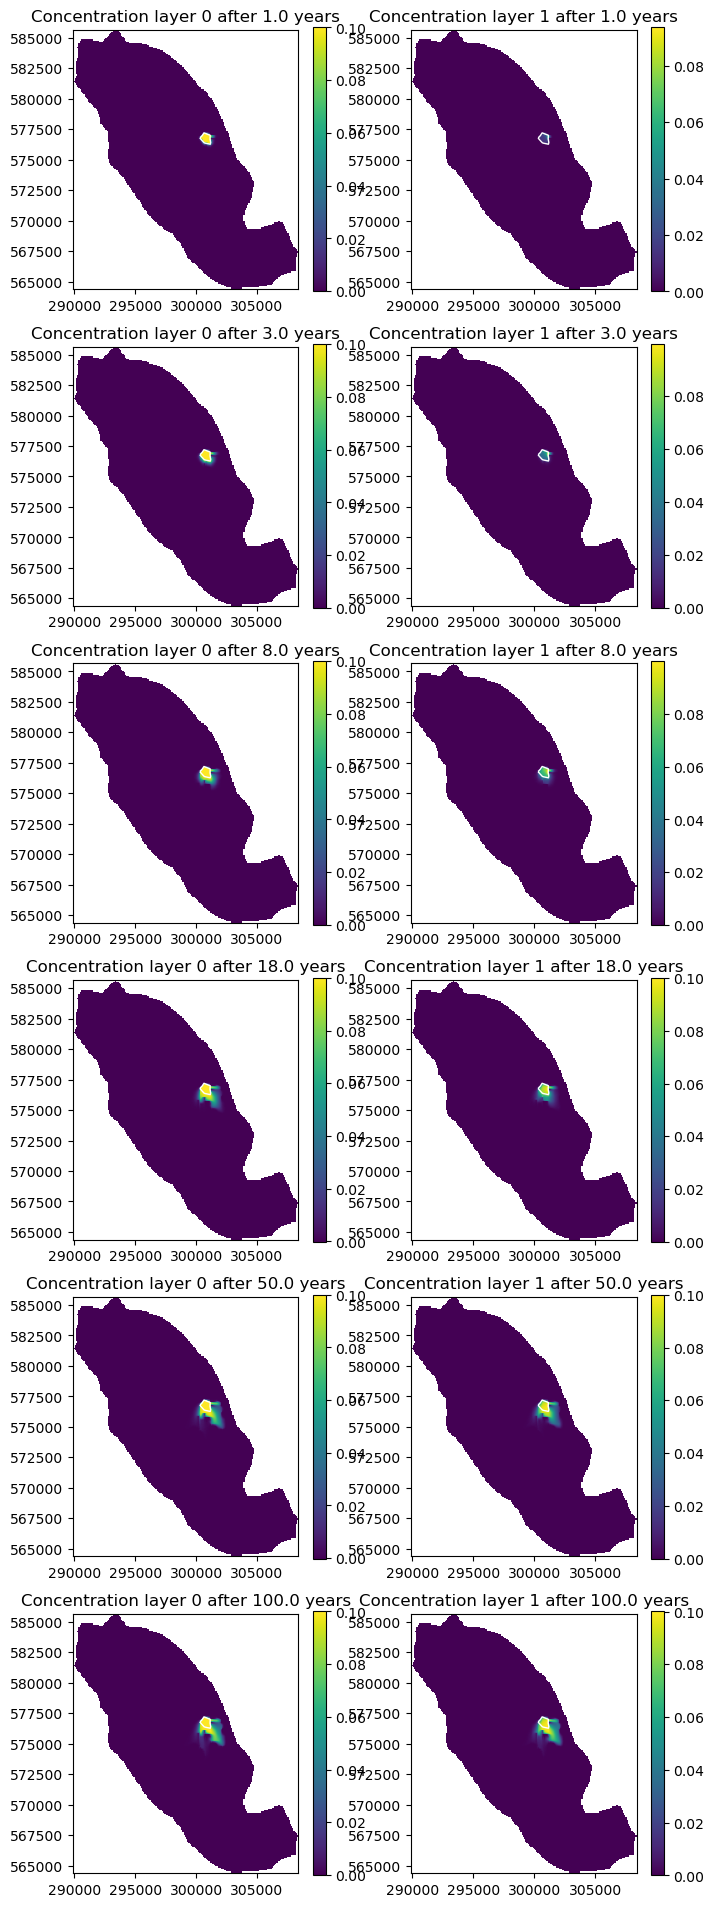

In [77]:
# Load the results file.
ucnobj = flopy.utils.UcnFile('MT3D001.UCN' )
times = ucnobj.get_times()
conc = ucnobj.get_alldata()
conc[conc==1e30] = np.nan
years = np.cumsum( perlen_mt ) / year

plt.figure(figsize=(4*2,4*nper_mt))

for idx in range( nper_mt):
  ax = plt.subplot(nper_mt, 2, idx*2+1)
  conc2d = np.squeeze( conc[idx,0,:,:] )
  im = plot_geo_raster( conc2d, basin_metadata)
  plt.colorbar( im )
  landfill_sf.plot(edgecolor='white', facecolor='none', ax=ax)
  plt.title( 'Concentration layer 0 after ' + str( years[idx]) + ' years' )

  ax = plt.subplot( nper_mt, 2, idx*2 + 2)
  conc2d = np.squeeze( conc[idx,1,:,:] )
  im = plot_geo_raster( conc2d, basin_metadata)
  plt.colorbar( im )
  landfill_sf.plot(edgecolor='white', facecolor='none', ax=ax)
  plt.title( 'Concentration layer 1 after ' + str( years[idx]) + ' years' )


In [78]:
!pip install vtk
from flopy.export import vtk as fv
from flopy.utils import postprocessing


is_superficial = np.zeros( (nlay, nrow, ncol))
is_superficial[0, basin[0,:,:] == basin_inside ] = 1

is_bedrock = np.zeros( (nlay, nrow, ncol))
is_bedrock[1:,  basin[0,:,:] == basin_inside ] = 1

spdisX, spdisY, spdisZ = postprocessing.get_specific_discharge((qx, qy, qz), mf,head )

vtkout = 'VTKout/Dumfries_VTK.vtk'

vtkobj = fv.Vtk(model=mf, vertical_exageration=10)
vtkobj.add_array( head, 'head')
vtkobj.add_array( hk, 'hk')
vtkobj.add_array( is_superficial, 'is_superficial')
vtkobj.add_array( is_bedrock, 'is_bedrock')
for idx in range( nper_mt):
  vtkobj.add_array( np.squeeze(conc[idx,:,:,:]), 'concentration_' + str( years[idx]) + '_years')
vtkobj.add_cell_budget(cbb)
vtkobj.add_array( spdisX, 'Specific_Discharge_X')
vtkobj.add_array( spdisY, 'Specific_Discharge_Y')
vtkobj.add_array( spdisZ, 'Specific_Discharge_Z')

vtkobj.write(vtkout)

del(vtkobj)




   ---------------------------------------- 0.0/58.5 MB ? eta -:--:--
   --- ------------------------------------ 5.5/58.5 MB 28.0 MB/s eta 0:00:02
   --------- ------------------------------ 13.6/58.5 MB 32.9 MB/s eta 0:00:02
   --------------- ------------------------ 22.0/58.5 MB 35.7 MB/s eta 0:00:02
   -------------------- ------------------- 30.7/58.5 MB 36.7 MB/s eta 0:00:01
   ------------------------- -------------- 37.2/58.5 MB 35.9 MB/s eta 0:00:01
   ------------------------------ --------- 44.0/58.5 MB 35.0 MB/s eta 0:00:01
   ----------------------------------- ---- 51.4/58.5 MB 35.9 MB/s eta 0:00:01
   ------------------------------------- -- 55.3/58.5 MB 32.9 MB/s eta 0:00:01
   ---------------------------------------  58.5/58.5 MB 33.3 MB/s eta 0:00:01
   ---------------------------------------- 58.5/58.5 MB 28.7 MB/s eta 0:00:00


# Export GIS Data

In [79]:
!pip install pyshp

mf.export('Dumfries_model_input.shp')
flopy.export.shapefile_utils.write_grid_shapefile('Dumfries_modelled_head.shp', mf.modelgrid, array_dict={'head_top' : head[0,:,:], 'head_bottom' :head[1,:,:] }, nan_val=-9999)


c:\Users\yisih\miniforge3\Lib\site-packages\flopy\export\shapefile_utils.py:306: UserWarning: Failed to get data for delc array, DIS package
  warn(
c:\Users\yisih\miniforge3\Lib\site-packages\flopy\export\shapefile_utils.py:306: UserWarning: Failed to get data for delr array, DIS package
  warn(
c:\Users\yisih\miniforge3\Lib\site-packages\flopy\export\shapefile_utils.py:306: UserWarning: Failed to get data for laycbd array, DIS package
  warn(
c:\Users\yisih\miniforge3\Lib\site-packages\flopy\export\shapefile_utils.py:306: UserWarning: Failed to get data for nstp array, DIS package
  warn(
c:\Users\yisih\miniforge3\Lib\site-packages\flopy\export\shapefile_utils.py:306: UserWarning: Failed to get data for perlen array, DIS package
  warn(
c:\Users\yisih\miniforge3\Lib\site-packages\flopy\export\shapefile_utils.py:306: UserWarning: Failed to get data for steady array, DIS package
  warn(
c:\Users\yisih\miniforge3\Lib\site-packages\flopy\export\shapefile_utils.py:306: UserWarning: Failed

In [80]:
flopy.export.utils.export_array(mf.modelgrid, 'head0.tif', head[0,:,:], nodata=-9999, fieldname='hydraulic head top')
flopy.export.utils.export_array(mf.modelgrid, 'head1.tif', head[1,:,:], nodata=-9999, fieldname='hydraulic head bottom')
flopy.export.utils.export_array(mf.modelgrid, 'concentration_top_step6.tif', conc[5,0,:,:], nodata=-9999, fieldname='concentration top')
flopy.export.utils.export_array(mf.modelgrid, 'concentration_bottom_step6.tif', conc[5,1,:,:], nodata=-9999, fieldname='concentration bottom')


c:\Users\yisih\miniforge3\Lib\site-packages\pyproj\crs\crs.py:1295: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


In [81]:
pthobj.write_shapefile(shpname='landfill_pathlines.shp', pathline_data=landfill_pathlines,  mg=mf.modelgrid, epsg=crs_epsg)

(numpy.record, [('particleid', '<i4'), ('particlegroup', '<i4'), ('timepointindex', '<i4'), ('cumulativetimestep', '<i4'), ('time', '<f4'), ('x', '<f4'), ('y', '<f4'), ('z', '<f4'), ('k', '<i4'), ('i', '<i4'), ('j', '<i4'), ('grid', '<i4'), ('xloc', '<f4'), ('yloc', '<f4'), ('zloc', '<f4'), ('linesegmentindex', '<i4')])


c:\Users\yisih\miniforge3\Lib\site-packages\flopy\export\shapefile_utils.py:496: UserWarning: Truncating shapefile fieldname particlegroup to partiroup_
  warn(f"Truncating shapefile fieldname {s} to {name}")
c:\Users\yisih\miniforge3\Lib\site-packages\flopy\utils\crs.py:121: PendingDeprecationWarning: the epsg argument will be deprecated and will be removed in version 3.6. Use crs instead.
  warnings.warn(
